In [34]:
%matplotlib notebook

In [35]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
from pysatellite import transformations, functions, filters, orbit_gen
import pysatellite.config as cfg

from skyfield.api import EarthSatellite, load, wgs84

In [36]:
sin = np.sin
cos = np.cos
pi = np.float64(np.pi)


class Sensor:
    def __init__(self):
        # Using Liverpool Telescope as location
        self.LLA = np.array([[np.deg2rad(28.300697)], [np.deg2rad(-16.509675)], [2390]], dtype='float64')
        # sensLLA = np.array([[pi/2], [0], [1000]], dtype='float64')
        self.ECEF = transformations.lla_to_ecef(self.LLA)
        self.ECEF.shape = (3, 1)
        self.AngVar = 1e-6
        self.RngVar = 20


sens = Sensor()
bluffton = wgs84.latlon(28.300697, -16.509675, 2390)

simLength = cfg.simLength
simLength = 50
stepLength = cfg.stepLength

In [37]:
file = os.getcwd() + '/../space-track_leo_tles_visible.txt'

with open(file) as f:
    tle_lines = f.readlines()

tles = {}
satellites = {}
ts = load.timescale()
for i in range(0, len(tle_lines) - 1, 2):
    tles['{i}'.format(i=int(i / 2))] = [tle_lines[i], tle_lines[i + 1]]
    satellites['{i}'.format(i=int(i / 2))] = EarthSatellite(line1=tles['{i}'.format(i=int(i / 2))][0],
                                                            line2=tles['{i}'.format(i=int(i / 2))][1])

In [38]:
num_sats = len(satellites)
# Get rough epoch using first satellite
epoch = satellites['0'].epoch.utc_datetime()
# Generate timestamps for each step in simulation
timestamps = []
for i in range(simLength):
    timestamps.append(ts.from_datetime(epoch+datetime.timedelta(seconds=i*stepLength)))

In [39]:
satAER = {'{i}'.format(i=i): np.zeros((3, simLength)) for i in range(num_sats)}
satECI = {'{i}'.format(i=i): np.zeros((3, simLength)) for i in range(num_sats)}
satVis = {'{i}'.format(i=i): True for i in range(num_sats)}
for i, c in enumerate(satellites):
    for j in range(simLength):
        # t = ts.from_datetime(epoch+datetime.timedelta(seconds=j*stepLength))
        t = timestamps[j]
        diff = satellites[c] - bluffton
        topocentric = diff.at(t)
        alt, az, dist = topocentric.altaz()
        satAER[c][:, j] = [az.radians, alt.radians, dist.m]
        satECI[c][:, j] = np.reshape(transformations.aer_to_eci(satAER[c][:, j], stepLength, j, sens.ECEF,
                                                                sens.LLA[0], sens.LLA[1]), (3,))

satECIMes, satAERMes = orbit_gen.gen_measurements(satAER, num_sats, satVis, simLength, stepLength, sens)

In [40]:
satAERVisible = {}
satECIVisible = {}
for i, c in enumerate(satAER):
    if all(i > 0 for i in satAER[c][:, 1]):
        satAERVisible[c] = satAER[c]
        satECIVisible[c] = satECI[c]

<IPython.core.display.Javascript object>


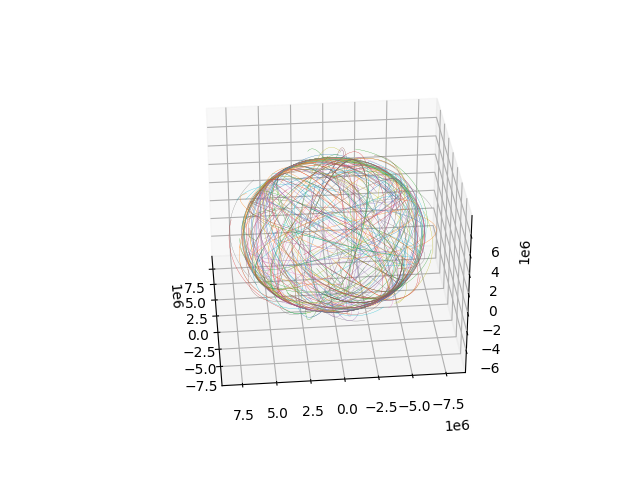

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, 35)
ax.set_aspect('auto')

for i, c in enumerate(satECI):
    ax.plot3D(satECI[c][0, :], satECI[c][1, :], satECI[c][2, :], linewidth=0.2)

plt.show()

<IPython.core.display.Javascript object>


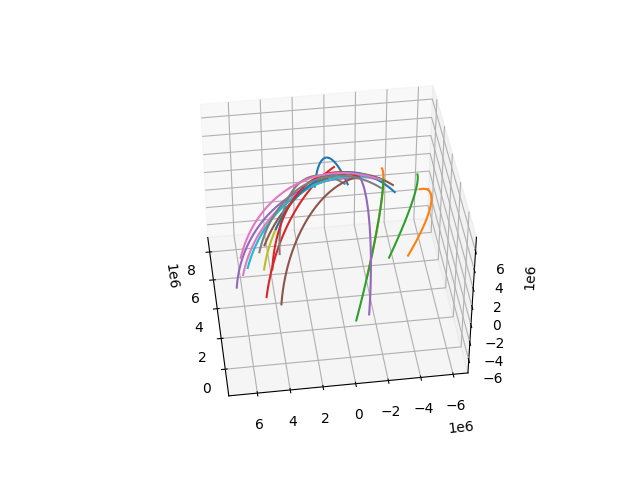

In [42]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, 35)
ax.set_aspect('auto')

for i, c in enumerate(satECIVisible):
    ax.plot3D(satECIVisible[c][0, :], satECIVisible[c][1, :], satECIVisible[c][2, :])

plt.show()

<IPython.core.display.Javascript object>


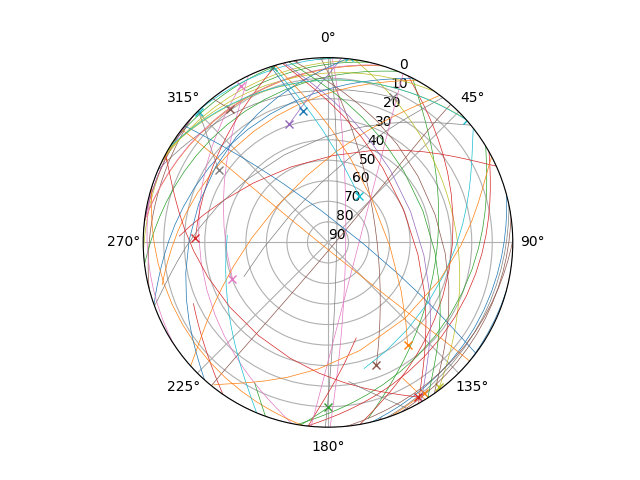

In [45]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_rlim(90, 0, 1)

for i, c in enumerate(satAER):
    ax.plot(satAER[c][0, :], np.rad2deg(satAER[c][1, :]), 'x-', linewidth=0.5, markevery=[-1])

plt.show()

<IPython.core.display.Javascript object>


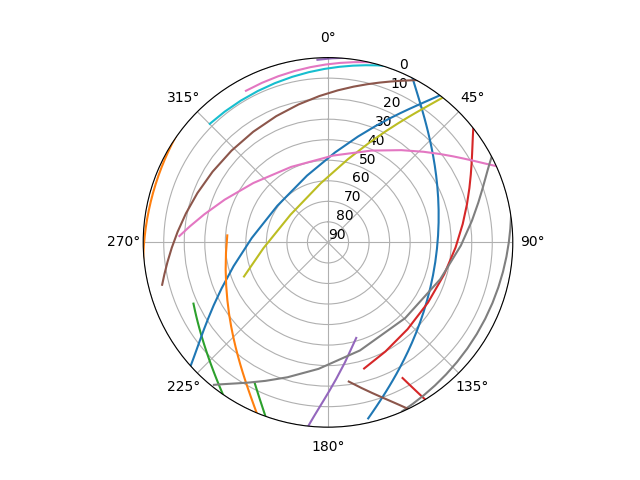

In [44]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_rlim(90, 0, 1)

for i, c in enumerate(satAERVisible):
    ax.plot(satAERVisible[c][0, :], np.rad2deg(satAERVisible[c][1, :]), 'x-', markevery=[-1])

plt.show()